# Aspartic acid benchmark

- Load reference trajectories (doi: 10.1063/1.4979519):
    - 'DFT': original reference geometries at B3LYP/6-311++G** *without* empirical dispersion
    - 'DFT2': original reference geometries reoptimized with empirical dispersion
    - 'MP2': original reference geometries at MP2/6-311++G**
    
- Load search data
    - Separate and count error files
    - Parse G16 log files and load:
    - cartesian coordinates in mdraj trajectory
    - rotatable bonds and energy in pandas dataframe
    - fit traj to first frame
    
- Calc RMSD matrix (n_search, n_ref): for each structure in search data count the number of structures within cutoff of a point in ref. data and viceversa; print number of points in ref. data without neighbours; print number of points in search data without ref.


## Load modules and set paths

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import os
import pandas as pd
import re
import scipy as sp
import subprocess as sub
import sys
from scipy import constants
import seaborn as sb
from sklearn.decomposition import PCA
import sklearn.preprocessing as prep
import sklearn.metrics as skmetrics
from matplotlib.ticker import MaxNLocator
import MDAnalysis as MDA
import MDAnalysis.analysis.rms as MDArms

In [2]:
%load_ext autoreload
sys.path.append("/home/gmancini/Dropbox/appunti/old_search_algos_28_08_2020/EvolutionaryAlgorithms/src")
sys.path.append("/home/gmancini/Dropbox/appunti/old_search_algos_28_08_2020/molecule_utils")
sys.path.append("/home/gmancini/Dropbox/appunti/Clustering/src/")
import zmatrix, ga_utils, cluster_utils, gau_parser, ga_population, create_db, metaea_utils, load_store
import myclusters, myvalidation
sys.path.append("/home/gmancini/data/devel/ML/Systems_for_paper2/AsparticAcid")
%autoreload 2

In [3]:
har2kjmol = constants.physical_constants["Avogadro constant"][0]\
*constants.physical_constants["Hartree energy"][0]/1000.
har2kjmol

2625.4996394798254

In [4]:
top_dir = "/home/gmancini/data/devel/ML/Systems_for_paper2/AsparticAcid"

In [5]:
os.chdir(top_dir)

In [6]:
def make_data(cutoff, traj1, traj2, RMSD):
    windows = np.arange(0,traj2.n_frames,50)
    data = np.empty((len(windows),7))
    for w,W in enumerate(windows):
        neighs = np.empty(traj1.n_frames,dtype='int')
        for ref_frame in range(traj1.n_frames):
            RR = RMSD[ref_frame,:W]
            within = RR[RR <= cutoff]
            neighs[ref_frame] = len(within)
        not_found = traj1.n_frames - np.count_nonzero(neighs)
        if not_found > 0:
            low_e  = np.count_nonzero(Energy[np.where([neighs==0])[1],3]<=15.)
            min_e = np.min(Energy[np.where([neighs==0])[1],3])
            ave_e = np.mean(Energy[np.where([neighs==0])[1],3])
            std_e = np.std(Energy[np.where([neighs==0])[1],3])
            sum_e = np.sum(Energy[np.where([neighs==0])[1],3])
        else:
            low_e = 0.
            min_e = 0.
            ave_e = 0.
            std_e = 0.
            sum_e = 0.           
        data[w] = [W, not_found, min_e, sum_e, ave_e, std_e, low_e]
    return data,neighs

## Load reference data

In [7]:
ref_dft = md.load("traj_b3lyp_superposed.pdb")
ref_dft

<mdtraj.Trajectory with 19 frames, 16 atoms, 1 residues, without unitcells at 0x7f36643682b0>

In [8]:
topology = ref_dft.topology
topology

<mdtraj.Topology with 1 chains, 1 residues, 16 atoms, 15 bonds at 0x7f36658ac820>

In [9]:
atmass = np.array([a.element.mass for a in topology.atoms],dtype=np.float32)
atmass

array([14.00672 ,  1.007947,  1.007947, 12.01078 ,  1.007947, 12.01078 ,
        1.007947,  1.007947, 12.01078 , 15.99943 , 15.99943 ,  1.007947,
       12.01078 , 15.99943 , 15.99943 ,  1.007947], dtype=float32)

In [10]:
heavyat = topology.select("(symbol =~ C) or (symbol =~ O) or (symbol =~ N)")
heavyat

array([ 0,  3,  5,  8,  9, 10, 12, 13, 14])

In [11]:
use_polar_hydrogens = True

In [12]:
if use_polar_hydrogens:
    atom_indices = np.append(heavyat,[1,11,15])

In [13]:
ref_mp2 = md.load("traj_mp2_superposed.pdb")
ref_mp2

<mdtraj.Trajectory with 19 frames, 16 atoms, 1 residues, without unitcells at 0x7f36640203d0>

## Preprocessing data for searches

In [14]:
zmat = zmatrix.zmat("asp_ref_order.tpl",[(1, 4), (4, 13), (13, 15), (4, 6), (6, 9), (9, 11)],fmt="gau")
RB = zmat.rot_bonds
RB

[(0, 3), (3, 12), (12, 14), (3, 5), (5, 8), (8, 10)]

In [15]:
molecule = ga_utils.linear_molecule("asp_ref_order.tpl",[(1, 4), (4, 13), (13, 15), (4, 6), (6, 9), (9, 11)])

# Load and check data from replica 1

In [16]:
run_dir = "/home/gmancini/data/devel/ML/Systems_for_paper2/AsparticAcid/dftba/"

In [17]:
log_prefix = "asp_dftba_constr_R1"
traj_prefix = "asp_dftba_constr_R1"

In [18]:
r1_dir = run_dir + "DFTBA_constr_R1/Log"
os.chdir(r1_dir)

In [19]:
RB

[(0, 3), (3, 12), (12, 14), (3, 5), (5, 8), (8, 10)]

In [20]:
if not os.path.isfile("traj_" + traj_prefix + ".pdb"):
    nfiles = len([name for name in os.listdir('.') if os.path.isfile(name)])
    print("Found ",nfiles," log files")
    Nok, Nerror, S1_DF = load_store.get_from_log(log_prefix, style="DFT", caller="g16", RB=RB, molecule=molecule)
    print("Success optimizations: {0:d} error optimizations {1:d}".format(Nok, Nerror))
    print("Loading xyz traj ...")
    traj = md.load("traj_" + traj_prefix+".xyz",top=top_dir+"/frame0_b3lyp.pdb")
    traj.save_pdb("traj_" + traj_prefix + ".pdb")
    pd.to_pickle(S1_DF, traj_prefix+".data.xz")
else:
    print("Loading pdb trajectory")
    traj = md.load("traj_" + traj_prefix + ".pdb")
    print(traj)
    files = os.listdir(r1_dir)
    L = len([i for i in files if re.search("log",i) is not None])
    print("{0:d} log files in directory, {1:d} not loaded".format(L,L-len(traj.xyz)))
    S1_DF = pd.read_pickle(traj_prefix+".data.xz")

Loading pdb trajectory
<mdtraj.Trajectory with 3086 frames, 16 atoms, 1 residues, without unitcells>
3138 log files in directory, 52 not loaded


### 2 Compare

In [21]:
EN = pd.to_numeric(S1_DF['energy'])
np.mean(EN), np.std(EN), np.max(EN), np.min(EN)

(-25.13344211674264, 0.009191890371559321, -25.07667657, -25.1592152965)

In [22]:
GEM1 = EN.idxmin()
GEM1, EN.loc[GEM1]

(0, -25.1592152965)

In [23]:
EN[EN==EN.loc[GEM1]].value_counts(),
EN[EN==EN.loc[GEM1]]

0   -25.159215
Name: energy, dtype: float64

In [24]:
S1_DF

,"(0, 3)","(3, 12)","(12, 14)","(3, 5)","(5, 8)","(8, 10)",energy,filename
0,-36.464006,14.537949,-176.917022,174.520959,-9.233957,179.185984,-25.159215,asp_dftba_constr_R1_00001.log.bz2
1,-170.475563,-138.079079,63.771662,-176.942745,38.153788,51.883719,-25.129296,asp_dftba_constr_R1_00002.log.bz2
2,179.814642,-148.986001,168.686084,-138.102197,113.649599,-143.885570,-25.147082,asp_dftba_constr_R1_00003.log.bz2
3,-179.999978,68.167347,-68.630215,95.994912,90.350474,-179.999967,-25.137169,asp_dftba_constr_R1_00004.log.bz2
4,94.916442,-60.607781,-96.608466,163.878002,80.820223,-82.639945,-25.119761,asp_dftba_constr_R1_00005.log.bz2
...,...,...,...,...,...,...,...,...
3081,-166.940162,-70.501754,-153.531217,-11.555565,80.860867,67.885297,-25.133144,asp_dftba_constr_R1_03134.log.bz2
3082,-166.940162,-70.501754,-153.531217,-11.555565,80.860867,67.885297,-25.133144,asp_dftba_constr_R1_03135.log.bz2
3083,-166.940162,-70.501754,-153.531217,-11.555565,80.860867,67.885297,-25.133144,asp_dftba_constr_R1_03136.log.bz2
3084,-166.940153,-70.501407,-153.532642,-11.555610,116.846314,179.999999,-25.143179,asp_dftba_constr_R1_03137.log.bz2


In [25]:
Edelta = har2kjmol*(EN.values - EN[GEM1])

(0.0, 50.0)

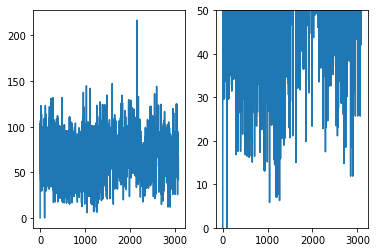

In [26]:
plt.subplot(121)
plt.plot(Edelta)

plt.subplot(122)
plt.plot(Edelta)
plt.ylim(0,50)

In [27]:
traj

<mdtraj.Trajectory with 3086 frames, 16 atoms, 1 residues, without unitcells at 0x7f366425bc40>

In [28]:
use_polar_hydrogens = False

In [29]:
heavyat

array([ 0,  3,  5,  8,  9, 10, 12, 13, 14])

In [30]:
windows = np.arange(0,traj.n_frames+100,100)
windows

array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100,
       2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100])

In [31]:
Energy = np.loadtxt(top_dir+"/Energies.txt")

In [32]:
cutoff = 0.02
use_polar_hydrogens = False

In [33]:
RMSD = np.empty((ref_mp2.n_frames, traj.n_frames))
if use_polar_hydrogens:
    for i in range(ref_mp2.n_frames):
        for j in range(traj.n_frames):
            X1 = ref_mp2[i].xyz[0]
            X2 = traj[j].xyz[0]
            rmsd = MDArms.rmsd(X1[atom_indices],X2[atom_indices],superposition=True,weights=atmass[atom_indices])
            RMSD[i,j] = rmsd
else:
    for i in range(ref_mp2.n_frames):
        for j in range(traj.n_frames):
            X1 = ref_mp2[i].xyz[0]
            X2 = traj[j].xyz[0]
            rmsd = MDArms.rmsd(X1[heavyat],X2[heavyat],superposition=True,weights=atmass[heavyat])
            RMSD[i,j] = rmsd    
RMSD.shape

(19, 3086)

In [34]:
data, neighs = make_data(cutoff,ref_mp2, traj, RMSD)

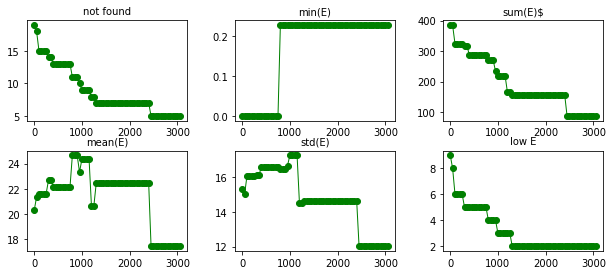

In [35]:
fig = plt.figure(figsize=(10,4), facecolor='w', edgecolor='k')

ax0 = plt.subplot(231)
plt.title('not found',fontsize=10)
plt.plot(data[:,0],data[:,1],'go-',linewidth=1)

ax1 = plt.subplot(232)
plt.title('min(E)',fontsize=10)
plt.plot(data[:,0],data[:,2],'go-',linewidth=1)
#ax1.yaxis.tick_right()

ax2 = plt.subplot(233)
plt.title('sum(E)$',fontsize=10)
plt.plot(data[:,0],data[:,3],'go-',linewidth=1)
#ax2.yaxis.tick_right()

ax3 = plt.subplot(234)
plt.title('mean(E)',fontsize=10)
plt.plot(data[:,0],data[:,4],'go-',linewidth=1)

ax4 = plt.subplot(235)
plt.title('std(E)',fontsize=10)
plt.plot(data[:,0],data[:,5],'go-',linewidth=1)

ax5 = plt.subplot(236)
plt.title('low E',fontsize=10)
plt.plot(data[:,0],data[:,6],'go-',linewidth=1)
#ax5.yaxis.tick_right()

plt.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)

plt.savefig(run_dir+"/Run1_Asp_dftba.png", dpi=300, bbox_inches="tight")

In [36]:
neighs

array([ 5,  1,  1,  6,  1,  0,  5,  0,  8,  0, 10,  0,  1, 12,  0, 25,  1,
        2,  2])

In [37]:
not_found = ref_mp2.n_frames - np.count_nonzero(neighs)
if not_found > 0:
    low_e  = np.count_nonzero(Energy[np.where([neighs==0])[1],3]<=15.)
    min_e = np.min(Energy[np.where([neighs==0])[1],3])
    ave_e = np.mean(Energy[np.where([neighs==0])[1],3])
    std_e = np.std(Energy[np.where([neighs==0])[1],3])
    sum_e = np.sum(Energy[np.where([neighs==0])[1],3])
    print(not_found, low_e, min_e, ave_e, std_e, sum_e)

5 2 0.22837120971355815 17.434433968648214 12.023236321539216 87.17216984324108


In [38]:
top_dir

'/home/gmancini/data/devel/ML/Systems_for_paper2/AsparticAcid'

In [39]:
windows = np.arange(0,traj.n_frames+100,100)
windows

array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100,
       2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100])

In [40]:
cutoff = 0.02
for W in windows:
    neighs = np.empty(ref_mp2.n_frames)
    for ref_frame in range(ref_mp2.n_frames):
        RR = RMSD[ref_frame,:W]
        within = RR[RR <= cutoff]
        neighs[ref_frame] = len(within)
    result = ref_mp2.n_frames - np.count_nonzero(neighs)
    print("After {0:d} optimizations {1:d} structures do not have neighbours".format(W,result))

After 0 optimizations 19 structures do not have neighbours
After 100 optimizations 15 structures do not have neighbours
After 200 optimizations 15 structures do not have neighbours
After 300 optimizations 14 structures do not have neighbours
After 400 optimizations 13 structures do not have neighbours
After 500 optimizations 13 structures do not have neighbours
After 600 optimizations 13 structures do not have neighbours
After 700 optimizations 13 structures do not have neighbours
After 800 optimizations 11 structures do not have neighbours
After 900 optimizations 11 structures do not have neighbours
After 1000 optimizations 9 structures do not have neighbours
After 1100 optimizations 9 structures do not have neighbours
After 1200 optimizations 8 structures do not have neighbours
After 1300 optimizations 7 structures do not have neighbours
After 1400 optimizations 7 structures do not have neighbours
After 1500 optimizations 7 structures do not have neighbours
After 1600 optimizations 7

In [41]:
np.where(neighs==0)[0]

array([ 5,  7,  9, 11, 14])

In [42]:
np.min(RMSD[np.where(neighs==0)[0]])

0.020742266267546473

In [43]:
np.min(RMSD[np.where(neighs==0)[0]])

0.020742266267546473

In [44]:
print(Energy[np.where(neighs==0)[0]])

[[-5.12492939e+02 -5.09638758e+02  5.66757943e+00  2.28371210e-01]
 [-5.12397599e+02 -5.09628941e+02  2.55983931e+02  2.60022527e+01]
 [-5.12491972e+02 -5.09630454e+02  8.20536113e+00  2.20291523e+01]
 [-5.12494828e+02 -5.09636283e+02  7.08877026e-01  6.72732298e+00]
 [-5.12490247e+02 -5.09626586e+02  1.27349282e+01  3.21850707e+01]]
